In [29]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from PIL import Image
import nibabel as nib
import os
import torch
import torch.nn as nn
import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
adc_images = []
dwi_images = []
masks = []
adc_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_2/img/adc"
dwi_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_2/img/dwi"
mask_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_2/mask"
for filename in os.listdir(adc_dir):
    if filename.endswith(".gz"):
        adc_path = os.path.join(adc_dir, filename)
        adc_img = nib.load(adc_path).get_fdata()
        adc_images.append(adc_img)
for filename in os.listdir(dwi_dir):
    if filename.endswith(".gz"):
        dwi_path = os.path.join(dwi_dir, filename)
        dwi_img = nib.load(dwi_path).get_fdata()
        dwi_images.append(dwi_img)
for filename in os.listdir(mask_dir):
    if filename.endswith(".gz"):
        mask_path = os.path.join(mask_dir, filename)
        mask_img = nib.load(mask_path).get_fdata()
        masks.append(mask_img)

In [3]:
adc_images[0].shape, dwi_images[0].shape, masks[0].shape

((64, 64), (64, 64), (64, 64))

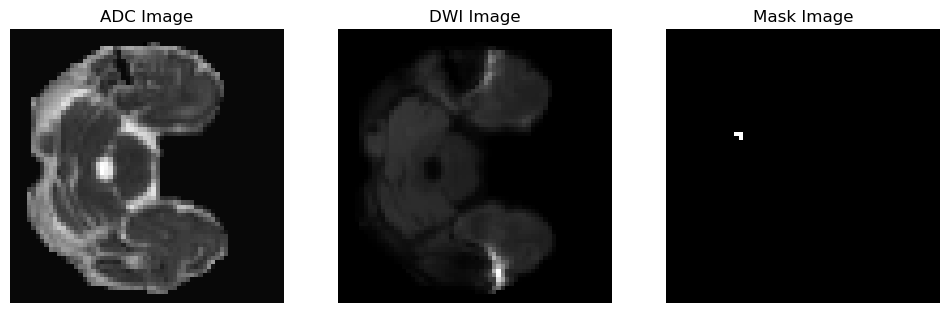

In [4]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(adc_images[0], cmap='gray')
plt.title('ADC Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(dwi_images[0], cmap='gray')
plt.title('DWI Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(masks[0], cmap='gray')
plt.title('Mask Image')
plt.axis('off')
plt.show()

In [5]:
adc_images = np.array(adc_images)
dwi_images = np.array(dwi_images)
masks = np.array(masks)
print(adc_images.shape, dwi_images.shape, masks.shape)

(1504, 64, 64) (1504, 64, 64) (1504, 64, 64)


In [6]:
X = np.stack((adc_images, dwi_images), axis=0)
y = masks[np.newaxis, ...]
print(X.shape, y.shape)

(2, 1504, 64, 64) (1, 1504, 64, 64)


In [20]:
# import segmentation_models_pytorch as smp

In [21]:
# model = smp.Unet(
#     encoder_name="resnet34",
#     encoder_weights="imagenet",
#     in_channels=2,
#     classes=1
# )

In [18]:
class DoubleConv(nn.Module): # Convolutional block with two convolutional layers followed by ReLU activations.
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.conv_op(x)
    
class DownSample(nn.Module): # Downsampling block with DoubleConv followed by MaxPooling. Returns both the output before pooling and after pooling.
    def  __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p # p is used for next layer input and down for skip connection
class UpSample(nn.Module): # Upsampling block with ConvTranspose2d followed by DoubleConv. Takes two inputs for skip connections.
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2 , kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels,out_channels)
    
    def forward(self,x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2],dim=1) # Concatenate along channel dimension. x1 is the upsampled tensor and x2 is the skip connection tensor.
        return self.conv(x)

In [19]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Encoder depth will be controlled by depth list
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        # Output
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)
    
        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


In [ ]:
DEVICE = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=2, num_classes=1)
model.to(DEVICE)

In [24]:
def normalize_data(X, y):
    X_norm = np.zeros_like(X)
    for i in range(X.shape[0]):  # For two channels
        X_norm[i] = (X[i] - X[i].min()) / (X[i].max() - X[i].min() + 1e-8)
    
    y_norm = (y > 0).astype(np.float32)
    
    return X_norm, y_norm

X_normalized, y_normalized = normalize_data(X, y)
print(f"Normalized X range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
print(f"Normalized y range: [{y_normalized.min():.3f}, {y_normalized.max():.3f}]")
print(f"Unique values in masks: {np.unique(y_normalized)}")


X_tensor = torch.FloatTensor(X_normalized).permute(1, 0, 2, 3)  # (samples, channels, H, W)
y_tensor = torch.FloatTensor(y_normalized).permute(1, 0, 2, 3)  # (samples, classes, H, W)

print(f"X tensor shape: {X_tensor.shape}")
print(f"y tensor shape: {y_tensor.shape}")

Normalized X range: [0.000, 1.000]
Normalized y range: [0.000, 1.000]
Unique values in masks: [0. 1.]
X tensor shape: torch.Size([1504, 2, 64, 64])
y tensor shape: torch.Size([1504, 1, 64, 64])


In [26]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor, test_size=0.25, random_state=42)

# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_test, y_val_test), batch_size=16, shuffle=False)
# test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)
print(f"Train shape {X_train.shape}, labels shape {y_train.shape}")

Train shape torch.Size([1128, 2, 64, 64]), labels shape torch.Size([1128, 1, 64, 64])


In [30]:
class Metrix:
    def __init__(self, threshold):
        self.threshold = threshold
    def dice_score(self, preds, labels):
        preds= torch.sigmoid(preds)
        preds = (preds > self.threshold).float()
        intersection = (preds * labels).sum(dim=(1, 2, 3))
        dice = (2 * intersection) / (preds.sum(dim=(1, 2, 3)) + labels.sum(dim=(1, 2, 3)) + 1e-8)
        return dice.mean().item()
    def f1_score(self, preds, labels):
        preds= torch.sigmoid(preds)
        preds = (preds > self.threshold).float()
        intersection = (preds * labels).sum(dim=(1, 2, 3))
        precision = intersection / (preds.sum(dim=(1, 2, 3)) + 1e-8)
        recall = intersection / (labels.sum(dim=(1, 2, 3)) + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        return f1.mean().item()
    
    def lesion_wise_accuracy(self, preds, labels):
        preds= torch.sigmoid(preds)
        preds = (preds > self.threshold).float()
        batch_size = preds.shape[0]
        correct_lesions = 0
        for i in range(batch_size):
            pred_lesion = (preds[i].sum() > 0).float()
            true_lesion = (labels[i].sum() > 0).float()
            if pred_lesion == true_lesion:
                correct_lesions += 1
        return correct_lesions / batch_size

In [31]:
metrix = Metrix(threshold=0.5)
dice_score = metrix.dice_score
f1_score = metrix.f1_score
lesion_wise_accuracy = metrix.lesion_wise_accuracy

In [34]:
def trainer_class(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter, scheduler=None):
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    train_dice_scores = []
    valid_dice_scores = []
    patience = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        validation_loss = 0.0
        dice = 0.0
        for batch_idx, (images, masks) in enumerate(tqdm.tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}")):
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images) #logits 
            # print(f"masks shape: {masks.shape}, outputs shape: {outputs.shape}")
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            preds = outputs > 0.5
            train_loss += loss.item() * images.size(0)
            dice+= dice_score(masks, preds)
        epoch_train_loss = train_loss / len(train_loader.dataset)
        training_losses.append(epoch_train_loss)
        epoch_dice_score = dice / len(train_loader.dataset)
        train_dice_scores.append(epoch_dice_score)
        # Validation
        model.eval()
        with torch.no_grad():
            for images, masks in tqdm.tqdm(test_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                # print(f"masks shape: {masks.shape}, outputs shape: {outputs.shape}")
                loss = criterion(outputs, masks)
                validation_loss += loss.item() * images.size(0)
                dice += dice_score(masks, (outputs > 0.5))
        epoch_val_loss = validation_loss / len(test_loader.dataset)
        validation_losses.append(epoch_val_loss)
        epoch_dice_score_val = dice / len(test_loader.dataset)
        valid_dice_scores.append(epoch_dice_score_val)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience = 0
        else:
            patience += 1
        if patience >= patience_counter:
            print("Early stopping triggered")
            break
        if scheduler:
            scheduler.step(epoch_val_loss)
    return training_losses, validation_losses, train_dice_scores, valid_dice_scores

In [35]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [36]:
training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device=DEVICE, patience_counter=7, scheduler=scheduler
)

Validation Epoch 1/30: 100%|██████████| 24/24 [00:00<00:00, 174.97it/s]


Epoch 1/30, Train Loss: 0.3899, Val Loss: 0.3025


Validation Epoch 2/30: 100%|██████████| 24/24 [00:00<00:00, 179.15it/s]


Epoch 2/30, Train Loss: 0.2693, Val Loss: 0.2459


Validation Epoch 3/30: 100%|██████████| 24/24 [00:00<00:00, 187.89it/s]


Epoch 3/30, Train Loss: 0.2308, Val Loss: 0.2141


Validation Epoch 4/30: 100%|██████████| 24/24 [00:00<00:00, 182.65it/s]


Epoch 4/30, Train Loss: 0.2021, Val Loss: 0.1927


Validation Epoch 5/30: 100%|██████████| 24/24 [00:00<00:00, 185.75it/s]


Epoch 5/30, Train Loss: 0.1760, Val Loss: 0.1672


Validation Epoch 6/30: 100%|██████████| 24/24 [00:00<00:00, 187.25it/s]


Epoch 6/30, Train Loss: 0.1561, Val Loss: 0.1492


Validation Epoch 7/30: 100%|██████████| 24/24 [00:00<00:00, 162.26it/s]


Epoch 7/30, Train Loss: 0.1388, Val Loss: 0.1304


Validation Epoch 8/30: 100%|██████████| 24/24 [00:00<00:00, 184.00it/s]


Epoch 8/30, Train Loss: 0.1244, Val Loss: 0.1234


Validation Epoch 9/30: 100%|██████████| 24/24 [00:00<00:00, 182.87it/s]


Epoch 9/30, Train Loss: 0.1117, Val Loss: 0.1037


Validation Epoch 10/30: 100%|██████████| 24/24 [00:00<00:00, 184.69it/s]


Epoch 10/30, Train Loss: 0.1011, Val Loss: 0.0969


Validation Epoch 11/30: 100%|██████████| 24/24 [00:00<00:00, 162.91it/s]


Epoch 11/30, Train Loss: 0.0904, Val Loss: 0.0882


Validation Epoch 12/30: 100%|██████████| 24/24 [00:00<00:00, 176.64it/s]


Epoch 12/30, Train Loss: 0.0822, Val Loss: 0.0819


Validation Epoch 13/30: 100%|██████████| 24/24 [00:00<00:00, 181.80it/s]


Epoch 13/30, Train Loss: 0.0760, Val Loss: 0.0708


Validation Epoch 14/30: 100%|██████████| 24/24 [00:00<00:00, 185.08it/s]


Epoch 14/30, Train Loss: 0.0697, Val Loss: 0.0655


Validation Epoch 15/30: 100%|██████████| 24/24 [00:00<00:00, 183.09it/s]


Epoch 15/30, Train Loss: 0.0647, Val Loss: 0.0605


Validation Epoch 16/30: 100%|██████████| 24/24 [00:00<00:00, 185.81it/s]


Epoch 16/30, Train Loss: 0.0586, Val Loss: 0.0559


Validation Epoch 17/30: 100%|██████████| 24/24 [00:00<00:00, 185.50it/s]


Epoch 17/30, Train Loss: 0.0539, Val Loss: 0.0541


Validation Epoch 18/30: 100%|██████████| 24/24 [00:00<00:00, 187.48it/s]


Epoch 18/30, Train Loss: 0.0505, Val Loss: 0.0483


Validation Epoch 19/30: 100%|██████████| 24/24 [00:00<00:00, 187.79it/s]


Epoch 19/30, Train Loss: 0.0467, Val Loss: 0.0465


Validation Epoch 20/30: 100%|██████████| 24/24 [00:00<00:00, 186.77it/s]


Epoch 20/30, Train Loss: 0.0438, Val Loss: 0.0500


Validation Epoch 21/30: 100%|██████████| 24/24 [00:00<00:00, 173.94it/s]


Epoch 21/30, Train Loss: 0.0419, Val Loss: 0.0412


Validation Epoch 22/30: 100%|██████████| 24/24 [00:00<00:00, 182.30it/s]


Epoch 22/30, Train Loss: 0.0379, Val Loss: 0.0393


Validation Epoch 23/30: 100%|██████████| 24/24 [00:00<00:00, 184.90it/s]


Epoch 23/30, Train Loss: 0.0367, Val Loss: 0.0354


Validation Epoch 24/30: 100%|██████████| 24/24 [00:00<00:00, 186.00it/s]


Epoch 24/30, Train Loss: 0.0345, Val Loss: 0.0351


Validation Epoch 25/30: 100%|██████████| 24/24 [00:00<00:00, 157.05it/s]


Epoch 25/30, Train Loss: 0.0316, Val Loss: 0.0329


Validation Epoch 26/30: 100%|██████████| 24/24 [00:00<00:00, 154.31it/s]


Epoch 26/30, Train Loss: 0.0303, Val Loss: 0.0326


Validation Epoch 27/30: 100%|██████████| 24/24 [00:00<00:00, 181.92it/s]


Epoch 27/30, Train Loss: 0.0287, Val Loss: 0.0317


Validation Epoch 28/30: 100%|██████████| 24/24 [00:00<00:00, 186.50it/s]


Epoch 28/30, Train Loss: 0.0285, Val Loss: 0.0318


Validation Epoch 29/30: 100%|██████████| 24/24 [00:00<00:00, 186.80it/s]


Epoch 29/30, Train Loss: 0.0258, Val Loss: 0.0281


Validation Epoch 30/30: 100%|██████████| 24/24 [00:00<00:00, 186.62it/s]

Epoch 30/30, Train Loss: 0.0257, Val Loss: 0.0270


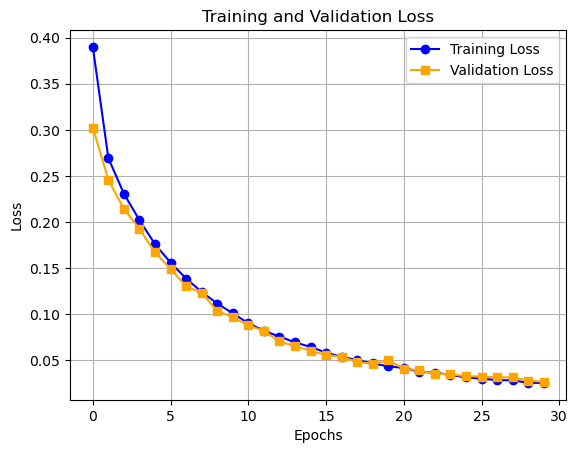

In [40]:
# plt.figure(figsize=(12, 5))
plt.plot(training_losses, label='Training Loss', color='blue', marker ='o')
plt.plot(validation_losses, label='Validation Loss', color='orange', marker ='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

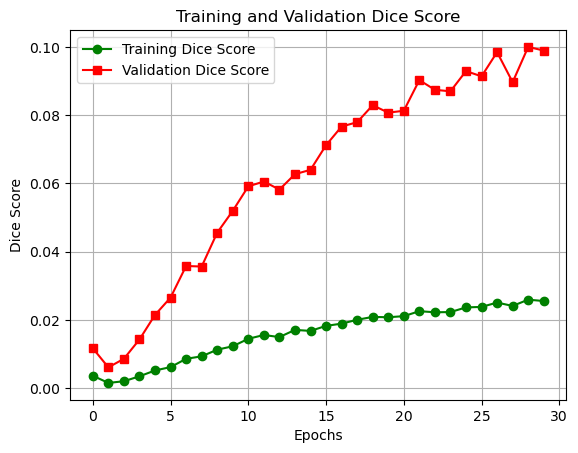

In [39]:
plt.plot(train_dice_scores, label='Training Dice Score', color='green', marker ='o')
plt.plot(valid_dice_scores, label='Validation Dice Score', color='red', marker ='s')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.grid()
plt.show()

In [38]:
def evaluate(model, test_loader, device, threshold=0.5):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.float32)

            output = model(img)  # logits
            output = torch.sigmoid(output)  # convert logits → probability

            preds.append(output.cpu())
            labels.append(label.cpu())

    # Concatenate all batches
    preds = torch.cat(preds, dim=0)         # shape: [N, 1, 64, 64]
    labels = torch.cat(labels, dim=0)       # shape: [N, 1, 64, 64]

    # Binarize predictions
    binary_preds = (preds >= threshold).float()

    return binary_preds, labels


In [155]:
outputs, labels = evaluate(model, test_loader, device='cuda', threshold=0.45)
outputs = outputs.squeeze(1)
labels = labels.squeeze(1)
outputs = outputs.numpy()
labels = labels.numpy()
print("Predictions shape:", outputs.shape)
print("Labels shape:", labels.shape)


Predictions shape: (226, 64, 64)
Labels shape: (226, 64, 64)


In [156]:
np.max(outputs), np.min(outputs), np.unique(outputs)

(np.float32(1.0), np.float32(0.0), array([0., 1.], dtype=float32))

In [161]:
iou, dice = compute_metrics(torch.tensor(outputs).unsqueeze(1), torch.tensor(labels).unsqueeze(1), threshold=0.45)
print(f"IoU: {iou:.4f}, Dice: {dice:.4f}")

IoU: 0.0131, Dice: 0.0243


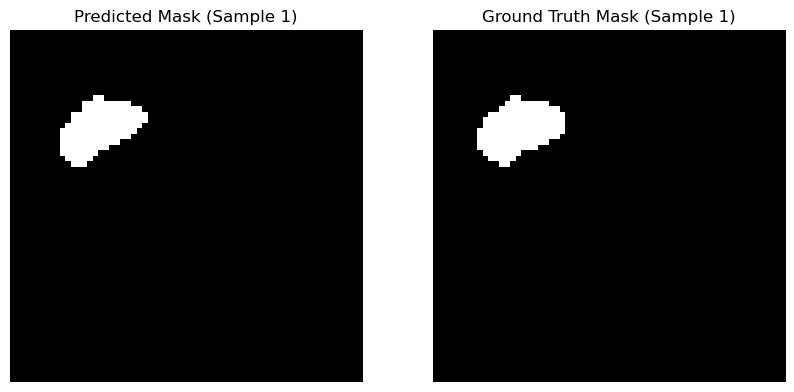

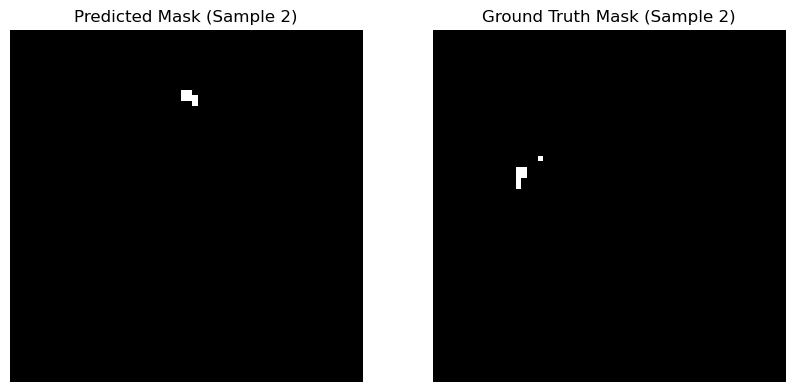

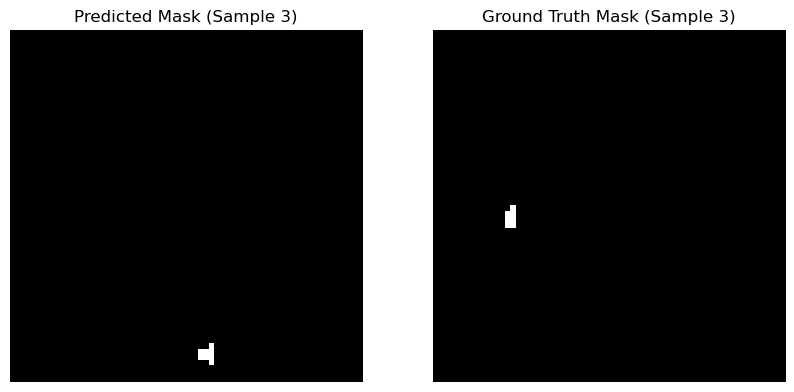

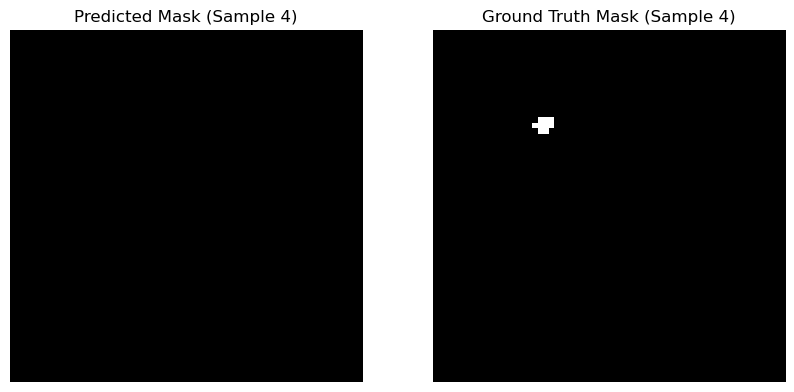

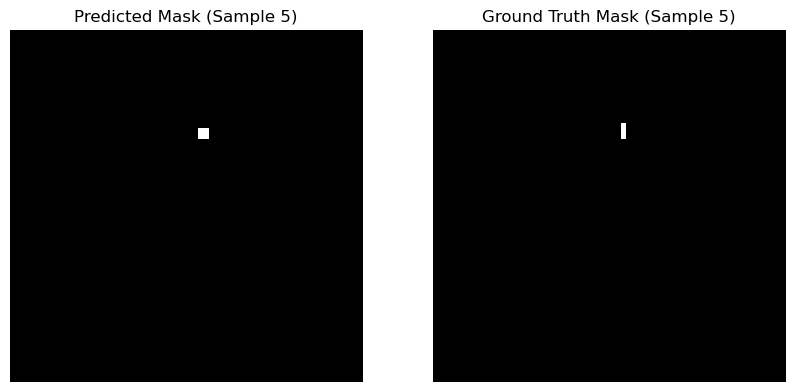

In [147]:
num_samples_to_plot = 5

for i in range(num_samples_to_plot):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(outputs[i], cmap='gray')
    plt.title(f'Predicted Mask (Sample {i+1})')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(labels[i], cmap='gray')
    plt.title(f'Ground Truth Mask (Sample {i+1})')
    plt.axis('off')
    plt.show()

In [ ]:
def compute_dice(y_pred, y_true):
    intersection = np.sum(y_pred * y_true)
    union = np.sum(y_pred) + np.sum(y_true)
    dice = (2.0 * intersection + 1e-8) / (union + 1e-8)
    return dice